# DiffEdit

## Reference

https://github.com/johnrobinsn/diffusion_experiments/blob/main/DiffEdit.ipynb

In [1]:
!pip install -qq numpy
!pip install -qq matplotlib
!pip install -qq fastai
!pip install -qq accelerate
!pip install -qq --upgrade transformers diffusers ftfy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.6 MB/s eta 0:00:00


In [2]:
import os
import numpy as np

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from fastcore.all import concat
from fastai.basics import show_image,show_images
from fastdownload import FastDownload
from pathlib import Path

from PIL import Image
import torch, logging
from torch import autocast
from torchvision import transforms as tfms

from huggingface_hub import notebook_login
from transformers import CLIPTextModel,CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL,UNet2DConditionModel,LMSDiscreteScheduler,StableDiffusionInpaintPipeline

import cv2

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

_s = lambda x: (x.shape, x.max(), x.min())

In [4]:
torch.manual_seed(1)

notebook_login()

In [141]:
def init_models(
    torch_dtype=torch.float16,
    device="cuda",
    model_precision_type="fp16",
    clip_path="openai/clip-vit-large-patch14",
    unet_path="CompVis/stable-diffusion-v1-4"
):
  # VAE model (deoding the latents into image space)
  vae = AutoencoderKL.from_pretrained(unet_path, subfolder="vae")

  # CLIP model (clip tokenizer: return token ids corresponding to prompt input)
  clip_tokenizer = CLIPTokenizer.from_pretrained(clip_path)
  clip_text_encoder = CLIPTextModel.from_pretrained(clip_path)

  # UNet model (predicting the noise for each time step)
  unet = UNet2DConditionModel.from_pretrained(unet_path, subfolder="unet")
  vae = vae.to(device)
  unet = unet.to(device)
  clip_text_encoder = clip_text_encoder.to(device)

  return vae, unet, clip_text_encoder, clip_tokenizer

In [142]:
vae, unet, clip, clip_tokenizer = init_models(device=device)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.17.self_attn.out_proj.weight', 'vision_model.encoder.layers.20.self_attn.k_proj.weight', 'vision_model.encoder.layers.15.self_attn.q_proj.bias', 'vision_model.encoder.layers.18.self_attn.k_proj.weight', 'vision_model.encoder.layers.17.mlp.fc1.bias', 'vision_model.encoder.layers.23.self_attn.q_proj.bias', 'vision_model.encoder.layers.10.layer_norm1.bias', 'vision_model.encoder.layers.8.layer_norm1.bias', 'vision_model.encoder.layers.2.self_attn.k_proj.bias', 'vision_model.encoder.layers.10.self_attn.k_proj.weight', 'vision_model.encoder.layers.23.self_attn.out_proj.bias', 'vision_model.encoder.layers.5.layer_norm2.bias', 'text_projection.weight', 'vision_model.encoder.layers.7.mlp.fc2.weight', 'vision_model.encoder.layers.1.self_attn.v_proj.bias', 'vision_model.encoder.layers.1.layer_norm2.bias', 'vision_model.encoder.layers.16.layer_norm1.bi

In [143]:
unet.config

FrozenDict([('sample_size', 64),
            ('in_channels', 4),
            ('out_channels', 4),
            ('center_input_sample', False),
            ('flip_sin_to_cos', True),
            ('freq_shift', 0),
            ('down_block_types',
             ['CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'DownBlock2D']),
            ('mid_block_type', 'UNetMidBlock2DCrossAttn'),
            ('up_block_types',
             ['UpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D']),
            ('only_cross_attention', False),
            ('block_out_channels', [320, 640, 1280, 1280]),
            ('layers_per_block', 2),
            ('downsample_padding', 1),
            ('mid_block_scale_factor', 1),
            ('act_fn', 'silu'),
            ('norm_num_groups', 32),
            ('norm_eps', 1e-05),
            ('cross_attention_dim', 768),
            ('e

In [144]:
diff_inpainting_path="runwayml/stable-diffusion-inpainting"
inpaint_model = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16",
    torch_dtype=torch.float16
).to(device)

safety_checker/model.safetensors not found
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [145]:
# vae model trained with a scale term to get closer to unit variance
vae_magic = 0.18215

## Demonstrate Image

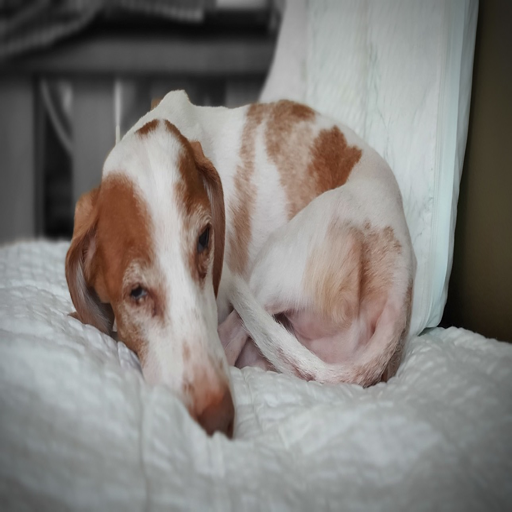

In [146]:
demo_img_url = 'https://github.com/Glanceyes/Image-Repository/blob/main/2023/06/25/20230625_1687680150.jpeg?raw=true'
demo_img = FastDownload().download(demo_img_url)

img_pl = Image.open(demo_img).resize((512,512))
img_pl

In [147]:
img = tfms.ToTensor()(img_pl).unsqueeze(0)
with torch.no_grad():
  # Normalize [0, 1] into [-1, 1]
  latent = vae.encode(img.to(device)*2-1)

  print(latent.__dict__)

{'latent_dist': <diffusers.models.vae.DiagonalGaussianDistribution object at 0x7f0a06cceef0>}


In [148]:
def image2latent(img):
  img = tfms.ToTensor()(img).unsqueeze(0)

  with torch.no_grad():
    # Normalize [0, 1] to [-1, 1]
    latent = vae.encode(img.to(device)*2-1)

  latent = latent.latent_dist.sample() * vae_magic
  return latent

In [149]:
def latents2images(latents):
  latents = latents / vae_magic

  with torch.no_grad():
    imgs = vae.decode(latents).sample

  # Denormalize [-1, 1] to [0, 1]
  imgs = (imgs / 2 + 0.5).clamp(0,1)
  imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
  imgs = (imgs * 255).round().astype("uint8")

  # Iterate to batch
  imgs = [Image.fromarray(i) for i in imgs]
  return imgs

In [150]:
def get_embedding_for_prompt(prompt):
  max_length = clip_tokenizer.model_max_length
  tokens = clip_tokenizer([prompt],
                          padding="max_length",
                          max_length=max_length,
                          truncation=True,
                          return_tensors="pt")

  with torch.no_grad():
    embeddings = clip(tokens.input_ids.to(device))[0]

  return embeddings

In [151]:
# Noise Scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

In [152]:
scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.00085),
            ('beta_end', 0.012),
            ('beta_schedule', 'scaled_linear'),
            ('trained_betas', None),
            ('use_karras_sigmas', False),
            ('prediction_type', 'epsilon')])

### Glance at Gaussian Noise with strength

In [153]:
scheduler.set_timesteps(50)

In [154]:
timesteps = scheduler.timesteps
timesteps

tensor([999.0000, 978.6122, 958.2245, 937.8367, 917.4490, 897.0612, 876.6735,
        856.2857, 835.8980, 815.5102, 795.1224, 774.7347, 754.3469, 733.9592,
        713.5714, 693.1837, 672.7959, 652.4082, 632.0204, 611.6327, 591.2449,
        570.8571, 550.4694, 530.0816, 509.6939, 489.3061, 468.9184, 448.5306,
        428.1429, 407.7551, 387.3673, 366.9796, 346.5918, 326.2041, 305.8163,
        285.4286, 265.0408, 244.6531, 224.2653, 203.8776, 183.4898, 163.1020,
        142.7143, 122.3265, 101.9388,  81.5510,  61.1633,  40.7755,  20.3878,
          0.0000], dtype=torch.float64)

In [155]:
len(timesteps)

50

In [156]:
offset = scheduler.config.get("steps_offset", 0)
offset

0

In [157]:
init_timestep = int(50 * 0.5) + offset
timesteps = scheduler.timesteps[-init_timestep]
timesteps

tensor(489.3061, dtype=torch.float64)

In [158]:
timesteps = torch.tensor([timesteps] * 1 * 1, device=device)
timesteps

tensor([489.3061], device='cuda:0', dtype=torch.float64)

## Predict Noise to Denoise Image Guided by the prompt

In [169]:
def predict_noise(
    text_embeddings,
    img_latents,
    seed=torch.seed(),
    guidance_scale=7,
    strength=0.5,
    **kwargs
):
  num_inference_steps = 50

  torch.manual_seed(seed)

  uncond = get_embedding_for_prompt('')
  text_embeddings = torch.cat([uncond, text_embeddings])

  scheduler.set_timesteps(num_inference_steps)

  offset = scheduler.config.get("steps_offset", 0)
  init_timestep = int(num_inference_steps * strength) + offset
  init_timestep = min(init_timestep, num_inference_steps)

  timesteps = scheduler.timesteps[-init_timestep]
  timesteps = torch.tensor([timesteps] * 1 * 1, device=device)

  start_step = init_timestep
  noise = torch.randn_like(img_latents)
  latents = scheduler.add_noise(img_latents, noise, timesteps=timesteps)
  latents = latents.to(device).float()

  t_start = max(num_inference_steps - init_timestep + offset, 0)
  timesteps = scheduler.timesteps[t_start:].to(device)

  noisy_latent = latents.clone()

  noise_pred = None

  for i, timestep in enumerate(timesteps):
    # With classifier free guidance,
    # both unconditional and conditional diffusion noise can be used simultaneously.
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep)

    with torch.no_grad():
      noise_pred = unet(latent_model_input,
                        timestep,
                        encoder_hidden_states=text_embeddings)["sample"]

    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

    u = noise_pred_uncond
    g = guidance_scale
    t = noise_pred_text

    noise_pred = u + g * (t - u)

    latents = scheduler.step(noise_pred, timestep, latents).prev_sample

  return latents2images(latents)[0], noise_pred

## Compute Mask

In [160]:
def calc_diffedit_samples(encoded, prompt1, prompt2, n=10, **kwargs):
  diffs=[]

  torch.manual_seed(torch.seed() if 'seed' not in kwargs else kwargs['seed'])

  seeds = torch.randint(0, 2**62, (10,)).tolist()

  for i in range(n):
    kwargs['seed'] = seeds[i]

    embed1 = get_embedding_for_prompt(prompt1)
    _img1, noise1 = predict_noise(embed1, encoded, **kwargs)

    embed2 = get_embedding_for_prompt(prompt2)
    _img2, noise2 = predict_noise(embed2, encoded, **kwargs)

    diffs.append((noise1 - noise2)[0].pow(2).sum(dim=0).pow(0.5)[None])

  all_masks = torch.cat(diffs)
  return all_masks

In [161]:
def calc_diffedit_diff(img_latent, prompt1, prompt2, **kwargs):
  m = calc_diffedit_samples(img_latent, prompt1, prompt2, **kwargs)
  m = m.mean(axis=0)
  m = (m - m.min()) / (m.max() - m.min())
  m = (m * 255.).detach().cpu().numpy().astype(np.uint8)
  m = Image.fromarray(m)
  return m

In [162]:
def process_diffedit_mask(m, threshold=0.35, **kwargs):
  m = np.array(m).astype(np.float32)
  m = cv2.GaussianBlur(m, (5,5), 1)
  m = (m > (255. * threshold)).astype(np.float32) * 255
  m = Image.fromarray(m.astype(np.uint8))
  return m

In [163]:
def calc_diffedit_mask(img_latent, prompt1, prompt2, **kwargs):
  m = calc_diffedit_diff(img_latent, prompt1, prompt2, **kwargs)
  m = process_diffedit_mask(m, **kwargs)
  m = m.resize((512,512))
  return m

In [164]:
def get_blended_mask(img, mask_gray):
  mask_rgb = mask_gray.convert('RGB')
  return Image.blend(img, mask_rgb, 0.40)

In [177]:
def diffedit(img_path, prompt1, prompt2, **kwargs):
  img_path = Path(img_path)
  out = []

  img = Image.open(img_path).resize((512,512))
  img_latent = image2latent(img)

  out.append(img)

  if 'seed' not in kwargs:
    kwargs['seed'] = torch.seed()

  mask = calc_diffedit_mask(img_latent, prompt1, prompt2, **kwargs)
  out.append(get_blended_mask(img, mask))
  out.append(inpaint_model(prompt=[prompt2], image=img, mask_image=mask,
    generator=torch.Generator(device).manual_seed(kwargs['seed'])).images[0]
  )
  show_images(out)

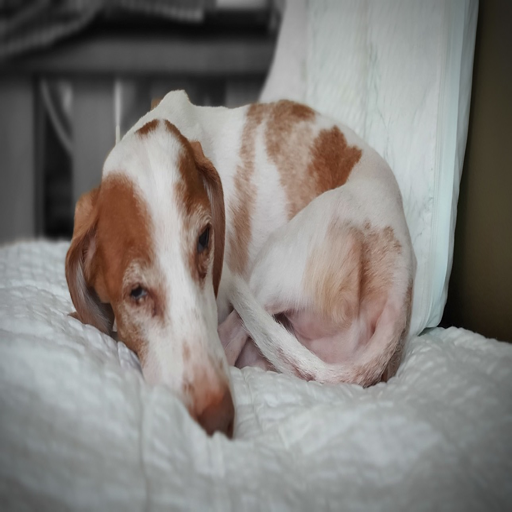

In [166]:
demo_img_url = 'https://github.com/Glanceyes/Image-Repository/blob/main/2023/06/25/20230625_1687680150.jpeg?raw=true'
demo_img = FastDownload().download(demo_img_url)

img = Image.open(demo_img).resize((512,512))
img

In [167]:
latent = image2latent(img)
latent.shape

torch.Size([1, 4, 64, 64])

seed: 12765083811071779585


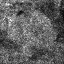

In [170]:
seed = 12765083811071779585

prompt_ref = 'sleeping dog'
prompt_query = 'sleeping cat'

print("seed:", seed)
mask = calc_diffedit_diff(latent, prompt_ref, prompt_query, seed=seed)
mask

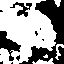

In [171]:
binarized_mask = process_diffedit_mask(mask)
binarized_mask

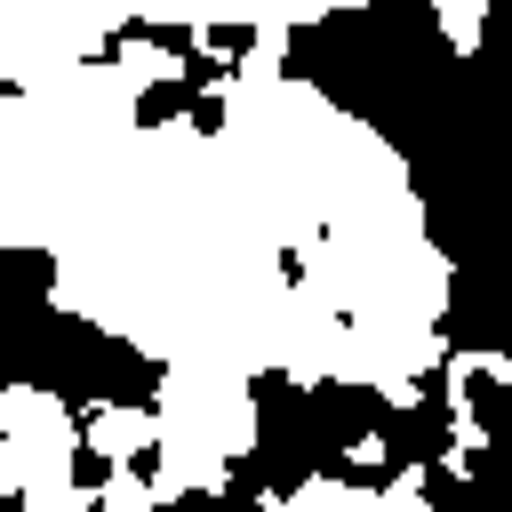

In [172]:
binarized_mask = binarized_mask.resize((512,512))
binarized_mask

  0%|          | 0/50 [00:00<?, ?it/s]

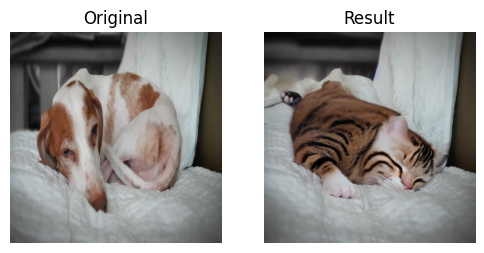

In [173]:
prompt_query = 'Sleeping cat'
generator = torch.Generator(device).manual_seed(seed)

img_result = inpaint_model(
    prompt=prompt_query,
    image=img,
    mask_image=binarized_mask,
    generator=generator
).images[0]

show_images([img, img_result], titles=['Original', 'Result'])

interactive(children=(FloatSlider(value=0.35, description='threshold', max=1.0, step=0.05), Output()), _dom_cl…

<function __main__.f(threshold)>

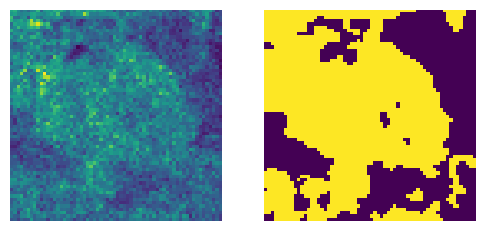

In [175]:
from ipywidgets import interact,FloatSlider

def f(threshold):
    show_images([mask,process_diffedit_mask(mask,threshold)])
    return

interact(f,threshold=FloatSlider(min=0.,max=1.,value=0.35,step=0.05))

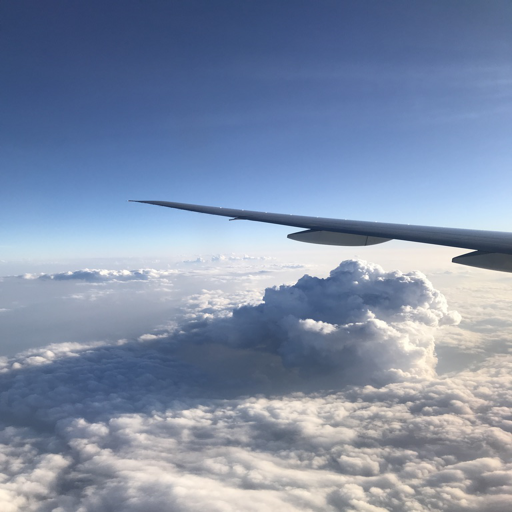

In [179]:
prompts = [
  ('View of sky from the airplane', 'View of sky watching from the rocket'),
  ('View of sky from the airplane', 'View of city watching from the airplane'),
  ('View of cloud from the airplane', 'View of city watching from the airplane'),
  ('View of cloud from the airplane', 'View of ocean watching from the airplane'),
]

test_image = "https://github.com/Glanceyes/Image-Repository/blob/main/2023/06/25/20230625_1687682485.jpeg?raw=true"

img_path = FastDownload().download(test_image)
img = Image.open(img_path).resize((512,512))
img

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

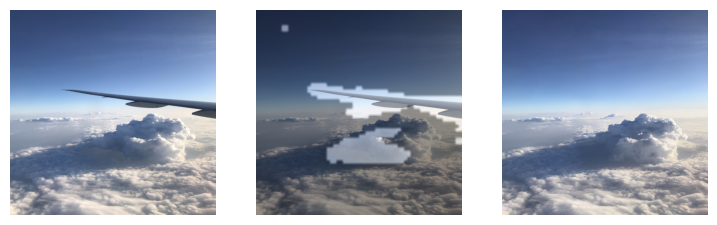

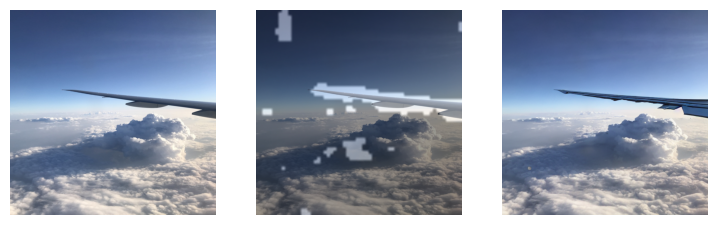

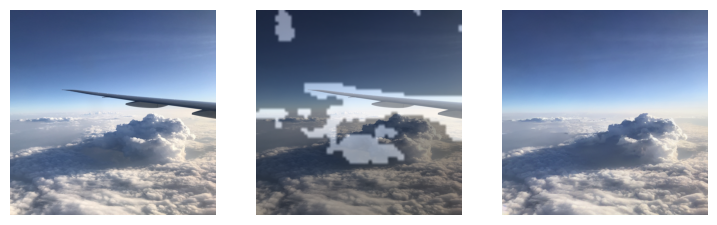

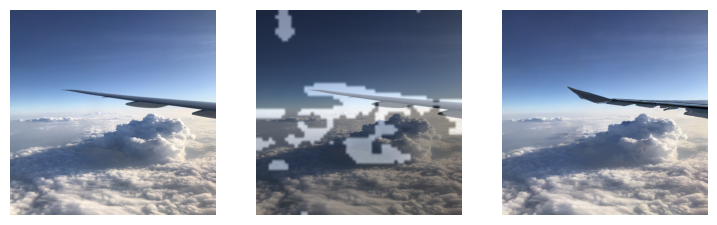

In [180]:
for p in prompts:
  diffedit(img_path, *p, seed=seed)

In [181]:
prompts = [
  ('sky', 'city'),
  ('cloud', 'ocean'),
  ('cloud', 'hurricane'),
]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

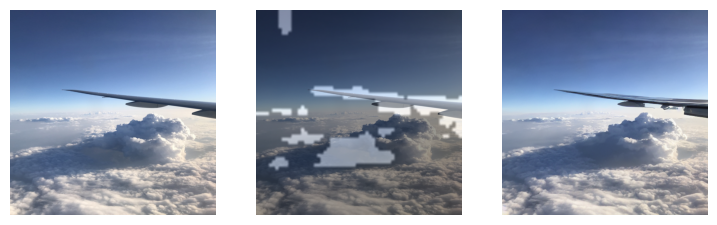

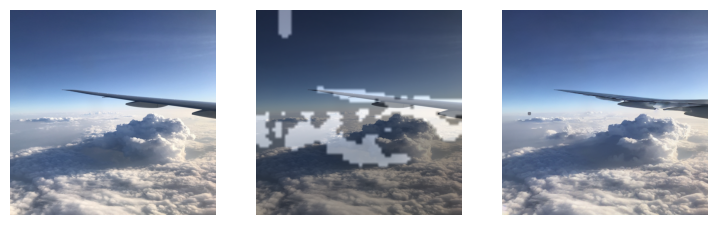

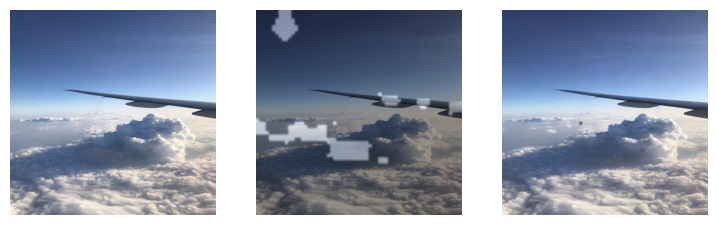

In [182]:
for p in prompts:
  diffedit(img_path, *p, seed=seed)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

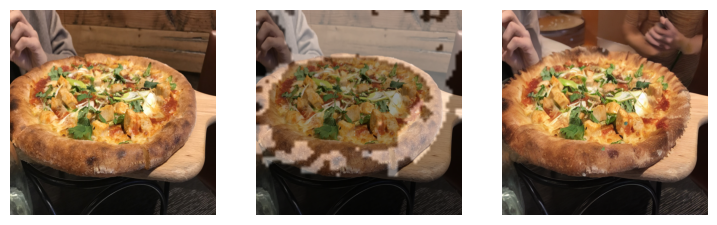

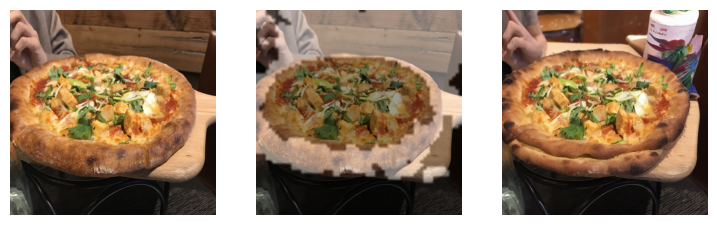

In [183]:
test_image = "https://github.com/Glanceyes/Image-Repository/blob/main/2023/06/25/20230625_1687683714.jpeg?raw=true"

prompts = [
  ('pizza', 'pasta'),
  ('pizza', 'hawaiian pizza')
]

img_path = FastDownload().download(test_image)
for p in prompts:
  diffedit(img_path, *p, seed=seed)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

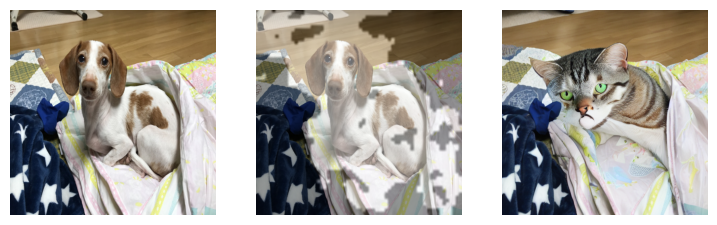

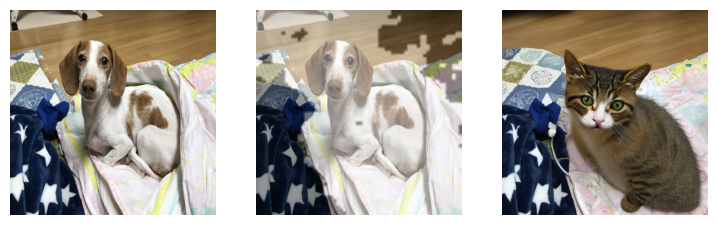

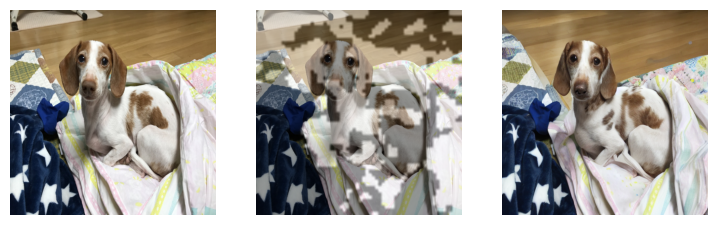

In [184]:
test_image = "https://github.com/Glanceyes/Image-Repository/blob/main/2023/06/25/20230625_1687684436.jpeg?raw=true"

prompts = [
  ('dog', 'cat'),
  ('dog sitting on the room', 'cat sitting on the room'),
  ('white dog with brown dots', 'black dog with white dots')
]

img_path = FastDownload().download(test_image)
for p in prompts:
  diffedit(img_path, *p, seed=seed)